# Visualizing a catalogue of galaxy clusters with CosmoBolognaLib

Full documentation for the CosmoBolognaLib C++/Python libraries (Marulli et al. 2011): http://federicomarulli.github.io/CosmoBolognaLib/Doc/html/index.html

In this notebook it is shown how to easily visualize a galaxy clusters distribution from a large cosmological simulation. The catalogue is extracted from the Magneticum Pathfinder Simulations, which are cosmological hydrodynamical simulations (http://www.magneticum.org/) (Dolag et. al, in preparation).
In this case the catalogue extracted is from a simulated box of given size: 896 Mpc/h, at redshift z = 2.00. It consists of $\sim$ 140000 particles having mass $1 \cdot 10^{14} M_\odot/h \leq M \leq 1 \cdot 10^{16}\ M_{\odot}/h$. We will consider as galaxy clusters all of the particles having mass $M_{500c} \geq 3.5 \cdot 10^{13}\ M\odot/h$. We will see how one can easily compute the density at every position of the clusters by using the implemented NDIM interpolator in the CosmoBolognaLib (CBL). We're gonna use the cbl::chainmesh::ChainMesh class, with which is possible to create a n-dimensional mesh grid for a sample of points and also to interpolate a function on them. Once we constructed a cubic (ipercubic in n-DIM) mesh, it is possible to search close objects to each of the points of our sample. The research is done in all the cells that falls closer than a given searching radius r_MAX, and only a given number N of closest points will be considered. Considering the mass of the clusters as ourfunction, we compute the density at each point by considering the ratio between the sum of the masses in these closest points and the volume of a sphere having a radius r_MAX. We then see how to show the visualization with python.

### Import CosmoBolognaLib libraries and python packages

In [2]:
import CosmoBolognaLib as cbl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib as mpl

### Let's define a cosmological model (not mandatory)

The Magneticum Simulations are a large set of cosmological simulations that follow the evolution of millions of particles, representing a galaxy (in this case), hence try to mimic the evolution and the growth of the biggest structure in our Universe. These simulations are divided in different simulation boxes, having different volumes and different resolutions. In our case the Box1 is a very large cosmological box, suited to study a statistical  of the distribution of matter in this simulation (clustering, cluster counts, voids statistics, ..). The underlying cosmological model with which the simulation were run is the WMAP7-years (Komatsu et al. 2011). The parameters of this model are listed below. With the use of the cbl::Cosmology class of the CBL, it is very easy to set a cosmological model having precisely this parameters value. Here we extract, as a trivial example, the information about the Look back time at the redshift we are considering $z = 2$.

In [3]:
redshift = 2.00

hh = 0.704                    # hubble constant, hh = H0/100
n_s = 0.963                   # spectral index of the primordial spectrum of fluctuations P(k) = A_s k^(n_s)
scalar_amp = 2.19e-9          # the scalar amplitude of the primordial spectrum of fluctuations A_s
scalar_pivot = 0.002          
Omega_M = 0.272
Omega_DE = 0.728
Omega_b = 0.0456
Omega_nu = 0.
Omega_radiation = 0.
massless_neutrinos = 3.04
massive_neutrinos = 0
w0 = -1.
wa = 0.
cosm = cbl.Cosmology(Omega_M, Omega_b, Omega_nu, massless_neutrinos, massive_neutrinos, Omega_DE, Omega_radiation, hh, scalar_amp, scalar_pivot, n_s, w0, wa)
cosm.set_sigma8(0.809)


# compute the lookback time
lookback = cosm.lookback_time(redshift)

print("Lookback time: t_0 = ", lookback)

Lookback time: t_0 =  10.396842434772909


### Read the catalogue from an external file

The catalogue consists of $\sim$ 140000 particles, and for each of them we know:

$X$ [Mpc/h]-- $Y$ [Mpc/h]-- $Z$ [Mpc/h]-- $V_x$ -- [km/s] $V_y$ -- [km/s] $V_z$ [km/s] --  $M_{500c}$ [$M_\odot/h$]

where {$X$,$Y$,$Z$} are the comoving coordinates of the given galaxy cluster, {$V_x$, $V_y$, $V_z$} its velocity and $M_{500c}$ is mass, defined as the mass enclosing a spherical overdensity $500$ times larger than $\rho_c$, the critical density of the Universe.

In [4]:
path_data = "/home/davide/MAGNETICUM/input/clusters/"
file_data = "ClusterCatalogue_comoving_z2.00.dat"

x, y, z, mass = np.genfromtxt(path_data+file_data, usecols=(0,1,2,6), unpack=True, skip_header=0)

### Create a cubic grid with the use of ChainMesh class from CosmoBolognaLib

The cbl::ChainMesh::norm_grid() function stretch the points sample into a cubic grid which sides going from -100 to 100.

In [5]:
cell_size = 2
nparams = 3
rMAX = 2
chmesh = cbl.ChainMesh(cell_size,nparams)

points = np.vstack((x, y, z))

chmesh.norm_grid(points, mass, rMAX)

print("Initialized the cubic grid")

Initialized the cubic grid


### Compute the matter density with a NDIM interpolation

The interpolation is done, for every point in the sample, by searching close objects which cells are found within rMAX. Next, only the closest N points are considered, with which is computed the mean of their mass. Finally, the density at a given point is computed by dividing the total amount of matter by the volume of a sphere having radius rMAX:

$\rho(x) = \frac{\sum_{i=1}^{N} m_i}{4/3 \pi r_{MAX}^3}$

In [6]:
N = 100

density = [0. for ii in range(0, len(x))]

for ii in range(0, len(x)):

    xi = [x[ii], y[ii], z[ii]]

    density[ii] = chmesh.interp_coord(xi, N)
    
print("Done with computing density")

Done with computing density


### Plot the spatial distribution of galaxy clusters in a 3D plot

The representation will be very simple. We're gonna scatter the points of the catalogue by setting the dimension of each point to be proportional to the mass, and imposing a colormap proportional to its local computed density. Also the opacity of each point will be proportional to the local density.

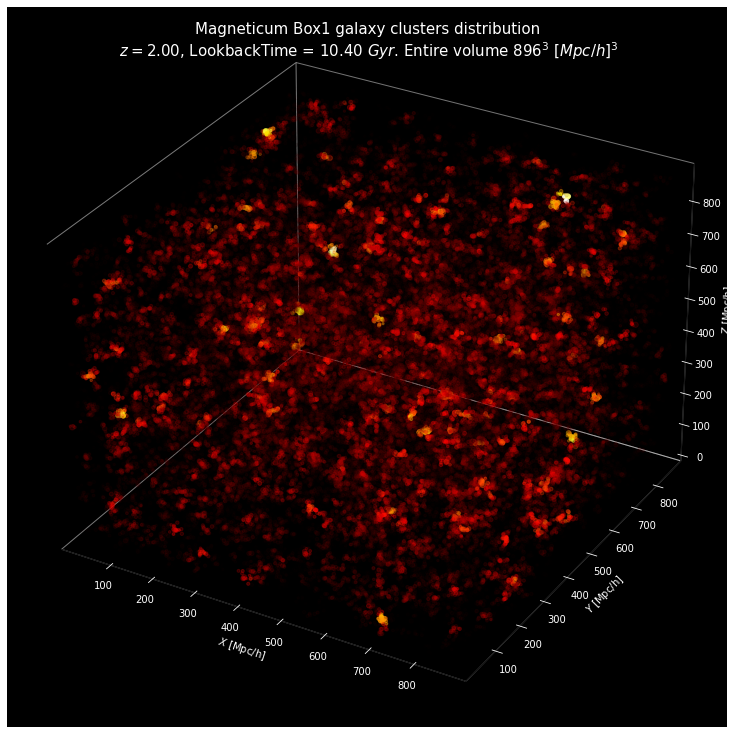

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

# Choose colormap
cmap = plt.cm.hot

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)                 # the colormap with opacity


# scatter of catalogue points
ax.scatter(x, y, z, marker='o', s=70*(np.array(mass)/1.e+15)**(1./3.),  c=np.array(density),  cmap = my_cmap, edgecolors=None
           , facecolors=np.array(density))
ax.set_xlabel("$X$ [Mpc/h]", fontsize=10)
ax.set_ylabel("$Y$ [Mpc/h]", fontsize=10)
ax.set_zlabel("$Z$ [Mpc/h]", fontsize=10)
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y), np.max(y))
ax.set_zlim(np.min(z), np.max(z))

# set the background color of the plot
ax.set_facecolor('black')

# make all the grids and lines of Axes3D invisibile
ax.grid(False)
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

# make the axes lines and ticks white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')  # only affects
ax.tick_params(axis='y', colors='white')  # tick labels
ax.tick_params(axis='z', colors='white')  # not tick marks

plt.suptitle("Magneticum Box1 galaxy clusters distribution\n $z = 2.00$, LookbackTime = {:.2f}".format(lookback)+" $Gyr$. Entire volume $896^3\ [Mpc/h]^3$", fontsize=15, x=0.50,y=0.98, color='w', fontweight='book')

plt.show()